In [17]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random
from scipy.signal import convolve
import scipy
from joblib import Parallel, delayed
import time
import sys
from scipy import sparse
import json
from tqdm import tqdm, tqdm_notebook
import matplotlib.gridspec as gridspec
import os
sys.path.insert(0, "../Scripts")
# from antigenicWaveSimulationMethods import main as coEvoSimulation
from coverage import elementwise_coverage, coverage_1D
from fitness import fitness, norm_fitness, phage_growth
from altImmunity import immunity_loss_uniform, immunity_gain_from_kernel
from initMethods import init_trail_nh, init_full_kernel, init_quarter_kernel, init_guassian_n, init_cond
from supMethods import time_conv, write2json, minmax_norm
from mutation import mutation
from randomHGT import get_time_next_HGT, HGT_logistic_event

In [24]:
params = { #parameters relevant for the equations
        "Nh":                     1E5,
        "N0":                     1E9, #This Will be updated by self-consitent solution
        "R0":                      20, 
        "M":                       10, #Also L, total number of spacers
        "mu":                      10, #mutation rate
        "gamma_shape":             20,
        "Np":                      10, #Number of Cas Protein
        "dc":                      10, #Required number of complexes to activate defence
        "h":                       10, #coordination coeff
        "r":                     1000, #cross-reactivity kernel
        "beta":                     0,
        "rate_HGT":                 0,
        "HGT_bonus_acq_ratio":      0,
        "rate_recovery":            0,
        "HGT_type":                 0,
        "n_spacer":                 1,
        "A":                        1,
    }
sim_params = { #parameters relevant for the simulation (including Inital Valuess)
        "continue":                 False, #DO NOT CREATE ARBITRARY FOLDERS ONLY FOR TESTS
        "xdomain":                  10000,
        "dim":                          1,
        "dx":                           1,
        "tf":                        4000,
        "dt":                           1,
        "dt_exact_fitness":             1,
        "dt_snapshot":                  1,
        "initial_mean_n":           [0,0],
        "initial_mean_nh":          [0,0],
        "conv_size":                 4000,
        "num_threads":                 32,
        "foldername":   "../Data_1D_Test",
        "seed":                         34,
        "hard_N0":                   False,
        "ndim":                         1,
    }

In [25]:
params, sim_params = init_cond(params, sim_params)
foldername = sim_params["foldername"]

try:
    write2json(foldername, params, sim_params)
except FileNotFoundError:
    os.mkdir(foldername)
    write2json(foldername, params, sim_params)


Assumptions Checks: 
mu >> 1 : mu = 10 >> 1
del_x << r : gamma_shape = 20 << r = 1000
v*tau >> sigma : v*tau = 1537.0195394105376 >> sigma = 28.439976181492547
uc << r : uc = 79.05641488347355 << r = 1000


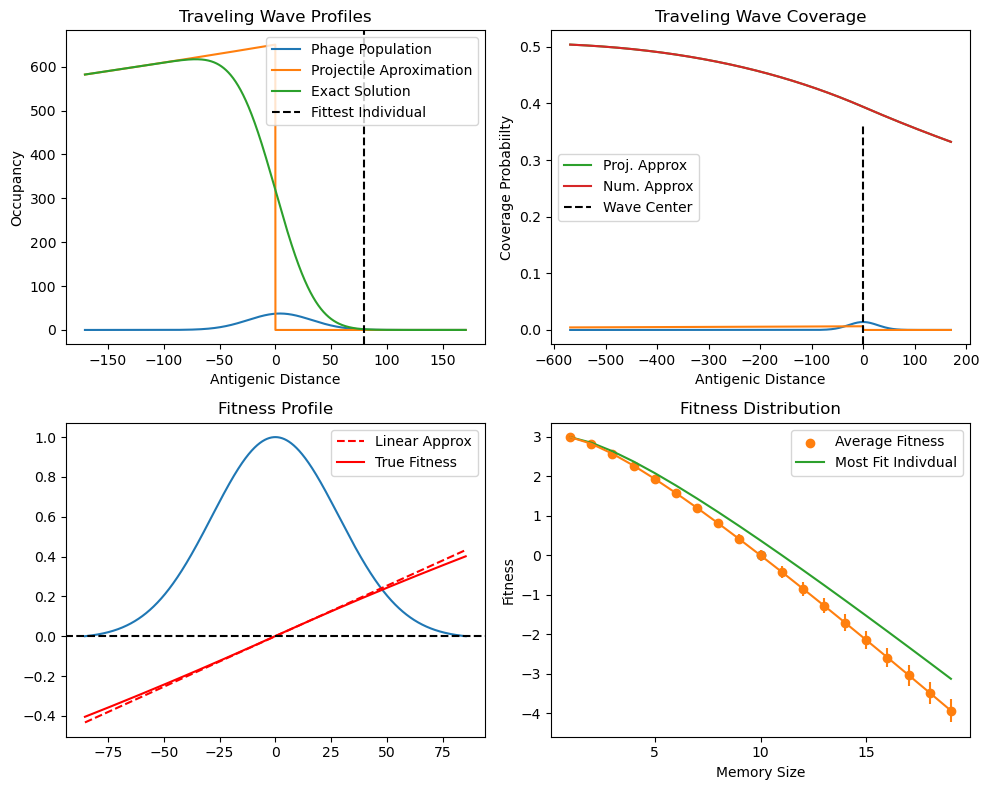

In [26]:
from formulas import plot_fitness_memory_dynamics, plot_wave_coverage, plot_wave_fitness, plot_wave_profiles
fig = plt.figure(figsize=(10, 8))

# Define the grid layout with 3 rows and 3 columns
gs = gridspec.GridSpec(2, 2)

# Create the first two rows (2x2 grid)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

# Plot something in each subplot
plot_wave_profiles(params, sim_params, ax1)
plot_wave_coverage(params, sim_params, ax2)
plot_wave_fitness(params, sim_params, ax3)
plot_fitness_memory_dynamics(params, sim_params, ax4)

# Adjust the layout
plt.tight_layout()

# Display the plot
plt.show()

In [27]:
from initMethods import init_1D_kernel


st1 = time.time()
n = init_guassian_n(params, sim_params)
nh = init_trail_nh(params, sim_params)
kernel_1D = init_1D_kernel(params, sim_params)
ed = time.time()
            
nh_total = params["Nh"]
n_total = params["N"]
uc = params["uc"]
sigma = params["sigma"]
M0 = params["M0"]
t = 0

with open(foldername+'/runtime_stats.txt','w') as file:
    file.write(f't: {t}| init_functions: {time_conv(ed-st1)}| Phage Population: {n_total:.4f}| Spacer Population: {nh_total:.4f}| Uc: {uc:.4f}| sigma: {sigma:.4f}| M0: {M0:.4f} \n')


In [29]:
x_domain = sim_params["xdomain"]

In [34]:
params["tau"]

374.53183520599254

(-150.0, 150.0)

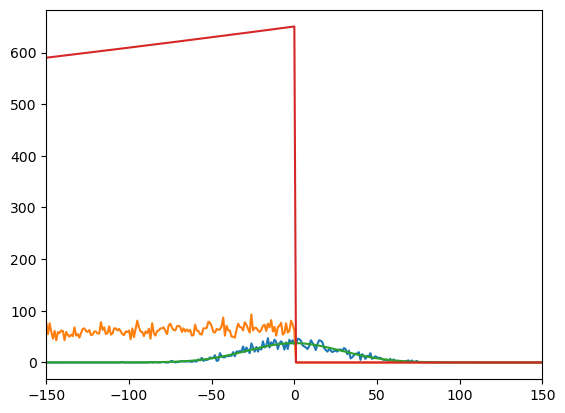

In [33]:
from formulas import gaussian1D, trail_exp


x_range = np.arange(-x_domain, x_domain, 1)
plt.plot(x_range, n)
plt.plot(x_range, nh)
plt.plot(x_range, gaussian1D(x_range, 0, params, sim_params))
plt.plot(x_range, trail_exp(x_range, 0, params, sim_params))
plt.xlim(-150, 150)

In [6]:
from mutation import num_mutants_per_loc_1D
A = num_mutants_per_loc_1D(n, params, sim_params)

In [7]:
p = coverage_1D(nh, kernel_1D, params, sim_params)
f = fitness(n, p, params, sim_params)
f = norm_fitness(f, n, params, sim_params) #renormalize f
n = phage_growth(n, f, params, sim_params, False) #update
n = mutation(n, params, sim_params)


In [8]:
params, sim_params, num_to_add, num_to_remove = HGT_logistic_event(t, n, params, sim_params)
nh_gain = immunity_gain_from_kernel(nh, n, None, params, sim_params, num_to_add) #update nh
nh = immunity_loss_uniform(nh_gain, n, params, sim_params, num_to_remove)

In [ ]:
while(t < sim_params["tf"]):

    str1:float = time.time()
    p = coverage_1D(nh, kernel_1D, params, sim_params)

    st2 = time.time()
    f = fitness(n, p, params, sim_params)
    f = norm_fitness(f, n, params, sim_params) #renormalize f
    n = phage_growth(n, f, params, sim_params, True) #update
            
    if (np.sum(n) <= 0) or (np.sum(n) >= (1/2)*np.sum(nh)):
        with open(foldername+'/runtime_stats.txt','a') as file:
            outstring = f"DEAD at: {t}| N: {np.sum(n)}| Coverage: {time_conv(st2-st1)}| Growth: {time_conv(st3-st2)}| Mutation: {time_conv(st4-st3)}| Immunity: {time_conv(ed-st4)} \n"
            file.write(outstring)

    st3 = time.time()
    n = mutation(n, params, sim_params)

    st4 = time.time()
    nh_prev = nh

    params, sim_params, num_to_add, num_to_remove = HGT_logistic_event(t, n, params, sim_params)
    nh_gain = immunity_gain_from_kernel(nh, n, None, params, sim_params, num_to_add) #update nh
    nh = immunity_loss_uniform(nh_gain, n, params, sim_params, num_to_remove)
            
    diff_of_acquisition = num_to_add-num_to_remove
    ed = time.time()

    with open(foldername+'/runtime_stats.txt','a') as file:
        M = params["M"]
        outstring = f"t: {t}| N: {np.sum(n)}| Coverage: {time_conv(st2-st1)}| Growth: {time_conv(st3-st2)}| Mutation: {time_conv(st4-st3)}| Immunity: {time_conv(ed-st4)}| M: {M:.4f}| Net_Acq_Diff: {diff_of_acquisition:.4f} \n"
        file.write(outstring)

    t += sim_params["dt"]

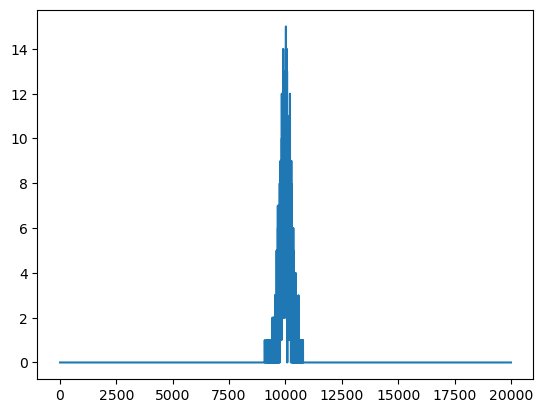

In [16]:
plt.plot(n)

In [6]:
from initMethods import init_dict_kernel

kernel_dict = init_dict_kernel(params, sim_params, type = "coverage", exponent = 1)

In [10]:
import os
import numpy as np

# Set the number of threads for OpenBLAS/MKL
os.environ["OMP_NUM_THREADS"] = "32"  # Set this to the desired number of threads
os.environ["OPENBLAS_NUM_THREADS"] = "32"
os.environ["MKL_NUM_THREADS"] = "32"
os.environ["VECLIB_MAXIMUM_THREADS"] = "32"
os.environ["NUMEXPR_NUM_THREADS"] = "32"

In [15]:
from copy import deepcopy
from scipy.spatial.distance import cdist

def lookup_value(val):
    val = float(val)
    return kernel_dict.get(val, 0.)

def convolve_subset(A, nonzero_values):
    print("Fuck this is happening")
    res = np.zeros(len_ind_n)

    # dist = cdist(A, B)

    for i in range(len_ind_n): #go through indexes of n
        dist = cdist(A, B[i, :].reshape(1,2))
        res[i] = np.dot(np.vectorize(lookup_value)(dist).squeeze(), nonzero_values)
        # res[i] = np.dot(np.vectorize(lookup_value)(dist[:, 0]).squeeze(), nonzero_values)
        # res[i] = np.dot(dist[:, 0], nonzero_values)
        # dist = dist[:, 1:]

Nh = params["Nh"]
M = params["M"]
# num_threads = 1
num_threads = sim_params["num_threads"]

x_ind_nh, y_ind_nh = nh.nonzero()
x_ind_n, y_ind_n = n.nonzero()

A = np.array([x_ind_nh, y_ind_nh]).transpose()
A_sets = np.array_split(A, num_threads, axis = 0)
B = np.array([x_ind_n, y_ind_n]).transpose()
len_ind_n = len(x_ind_n)

input_h = np.divide(nh, Nh*M)
nonzero_values = np.array(input_h[x_ind_nh, y_ind_nh].toarray()).squeeze()

x_nh_sets = np.array_split(x_ind_nh, num_threads)
y_nh_sets = np.array_split(y_ind_nh, num_threads)
# result_values = convolve_subset(A, input_h)
# kernel_dict_copies = [deepcopy(kernel_dict) for _ in range(num_threads)]



# nonzero_values_sets = np.array_split(nonzero_values, num_threads)
# results = Parallel(n_jobs=num_threads, backend="loky")(delayed(convolve_subset)
#         (A, nonzero_values)
#             for A, nonzero_values
#                 in zip(A_sets, nonzero_values_sets))

# result_values = sum_parallel(results, num_threads)
# res = scipy.sparse.dok_matrix(n.shape, dtype=float)
# res[x_ind_n, y_ind_n] = result_values

In [ ]:
from copy import deepcopy
from scipy.spatial.distance import cdist
from multiprocessing import Manager, Pool

# Function to perform the dictionary lookup
def lookup_value(shared_dict, key):
    return shared_dict.get(key, 0)

def parallel_lookup(shared_dict, keys_to_lookup):
    # Create a pool of workers
    with Pool(processes= num_threads) as pool:
        # Perform parallel lookup
        results = pool.starmap(lookup_value, [(shared_dict, key) for key in keys_to_lookup])
    return results

Nh = params["Nh"]
M = params["M"]
# num_threads = 1
num_threads = sim_params["num_threads"]

x_ind_nh, y_ind_nh = nh.nonzero()
x_ind_n, y_ind_n = n.nonzero()

len_ind_n = len(x_ind_n)

input_h = np.divide(nh, Nh*M)

x_nh_sets = np.array_split(x_ind_nh, num_threads)
y_nh_sets = np.array_split(y_ind_nh, num_threads)

nonzero_values = np.array(input_h[x_ind_nh, y_ind_nh].toarray()).squeeze()
nonzero_values_sets = np.array_split(nonzero_values, num_threads)


results = parallel_lookup(kernel_dict, )


In [25]:
foldername = "../Data/test13"
with open(foldername + "/params.json") as json_file:
    params = json.load(json_file)
with open(foldername + "/sim_params.json") as json_file:
    sim_params = json.load(json_file)

i = 999
kernel_quarter = init_quarter_kernel(params, sim_params)

n = sparse.load_npz(foldername+f"/sp_frame_n{i}.npz").todok()
nh = sparse.load_npz(foldername+f"/sp_frame_nh{i}.npz").todok()